## 파이토치 기초(5) - RNN

* day 1 - 텐서와 Autograd : https://dacon.io/codeshare/4478
* day 2 - 신경망모델 구현하기 : https://dacon.io/codeshare/4495
* day 3 - DNN : https://dacon.io/codeshare/4532
* day 4 - CNN : https://dacon.io/codeshare/4537
* day 5 - AutoEncoder 오토 인코더 : https://dacon.io/codeshare/4551

#### 개요
* I live to eat 과 I eat to live는 모두 같은 단어로 이루어졌지만 'live'와 'eat'의 위치가 뒤바뀌면 뜻이 완전히 달라짐을 알 수 있습니다.
* 일반적인 신경망 구조로는 단어의 특징만 잡아내기 때문에 이 변화를 인식하기 힘듭니다.
* 오늘의 목표는 데이터의 순서가 주는 정보까지 인지하는 새로운 형태의 신경망을 배우는 것입니다.
* RNN(Recurrent Neural Network)은 데이터가 나열된 순차적 데이터(Sequential Data) 혹은 시계열 데이터(Time Series Data)의 정보를 받아 전체 내용을 학습합니다.

#### RNN
* RNN은 정해지지 않은 길이의 배열을 읽고 설명하는 신경망입니다. RNN의 출력은 순차적 데이터의 흐름을 모두 내포합니다.
* RNN은 시계열 데이터의 정보를 하나씩 입력받을 때마다 지금까지 입력된 벡터들을 종합해 은닉 벡터(hidden vector)를 만들어냅니다.
* RNN 계열 신경망들은 대표적인 시계열 데이터인 텍스트와 자연어를 처리하고 학습하는 데 주로 사용됩니다. 오늘날에는 LSTM(Long Short Term Memory), GRU(Gated Recurrent Unit) 등 응용 RNN이 개발되어 언어 모델링(Language Modeling), 텍스트 감정 분석(text sentiment analysis), 기계 번역(Machin Translation) 등의 분야에 활발하게 이용되고 있습니다.

### 영화 리뷰 감정 분석

* 데이터의 순서 정보를 학습한다는 점에서 RNN은 CIFAR-10 같은 정적 데이터보다는 동영상, 자연어, 주가 등 동적인 데이터를 이용할 때 성능이 극대화 됩니다.
* IMDB는 텍스트 형태의 데이터셋으로 영화리뷰 5만 건으로 이루어져 있습니다. 각 리뷰는 다수의 영어 문장으로 구성되어 있으며, 긍정적 영화 리뷰는 2로, 부정적인 영화 리뷰는 1로 레이블링 되었습니다. 
* 영화 리뷰 텍스트를 RNN에 입력해 영화평 전체 내용을 압축하고 이렇게 압축된 리뷰가 긍정적인지 부정적인지 판단해주는 간단한 분류 모델을 만들어 보겠습니다.

#### cf) 토크나이징과 워드 임베딩
* 자연어 텍스트를 인공신경망에 입력시키려면 전처리 과정을 거쳐 데이터를 숫자로 나타내야 합니다.
* 가장 먼저 해야 할 일은 '언어의 최소 단위'인 토큰(token)으로 나누는 것입니다.
* 간단한 데이터셋이라면 파이썬의 split()함수를 사용해 단어단위로 토크나이징(tokenizing)해도 큰 문제는 없지만, 더 좋은 성능을 내고 싶다면 SpaCy같은 오픈 소스 라이브러리를 사용하는 것을 추천합니다.
* 문장 속 모든 토큰을 각각의 벡터로 나누어 주기 위해 데이터셋의 모든 단어(토큰) 수 만큼의 벡터를 담는 사전(dictionary)를 정의해야 합니다. 이렇게 언어의 최소 단위인 토큰을 벡터 형태로 변환하는 작업을 워드 임베딩(word embedding)이라고 합니다.

In [9]:
# 라이브러리 임포트
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.legacy import datasets, data # 자연어 데이터셋을 다루기 위해 토치비전이 아닌 토치 텍스트를 사용합니다.

# 하이퍼파라미터 정의
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cpu


In [10]:
# 데이터 로딩하기
# 텍스트 형태의 영화 리뷰들과 그에 해당하는 리뷰들을 텐서로 바꿔주기
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
# sequential = True : 데이터셋이 순차적인 데이터셋임을 명시
# batch_first = True : 신경망에 입력되는 텐서의 첫 번째 차원값을 batch size로 지정
# lower = True : 텍스트 데이터 속 모든 영문 알파벳이 소문자가 되도록 처리
LABEL = data.Field(sequential=False, batch_first=True) #Label은 순차적 데이터가 아님
trainset, testset = datasets.IMDB.splits(TEXT, LABEL) # train test 분리
TEXT.build_vocab(trainset, min_freq=5) # 워드 임베딩에 필요한 단어 사전(word vocabulary) 만들기
# min_freq = 5 : 학습 데이터에서 최소 5번 이상 등장한 단어만을 사전에 담음
LABEL.build_vocab(trainset)

# 학습용 데이터를 학습셋 80% 검증셋 20% 로 나누기
trainset, valset = trainset.split(split_ratio=0.8)
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)


vocab_size = len(TEXT.vocab) #사전 속 단어들의 개수와 레이블 수 지정
n_classes = 2

print("[학습셋]: %d [검증셋]: %d [테스트셋]: %d [단어수]: %d [클래스] %d"
      % (len(trainset),len(valset), len(testset), vocab_size, n_classes))

downloading aclImdb_v1.tar.gz


100%|█████████████████████████████████████████████████████████████████████████████| 84.1M/84.1M [00:30<00:00, 2.80MB/s]


[학습셋]: 20000 [검증셋]: 5000 [테스트셋]: 25000 [단어수]: 46159 [클래스] 2


* RNN의 입력이 길어지면 기울기(경사도) 폭발(gradient explosion) 혹은 기울기(경사도) 소실(vanishing gradient)이 발생 가능합니다
* 이러한 단점이 보완된 것이 GRU(Gated Recurrent Unit)로, GRU는 시계열 데이터 속 벡터 사이의 정보 전달량을 조절함으로써 기울기를 적정하게 유지하고 문장 앞부분의 정보가 끝까지 도달할 수 있도록 돕습니다.
* GRU에는 시계열 데이터 내 정보 전달량을 조절하는 업데이트 게이트(update gate)와 리셋 게이트(reset gate)라는 개념이 존재합니다.
* 리셋 게이트는 새로운 입력이 이전 은닉 벡터와 어떻게 조합하는지를 결정합니다.

In [11]:
# RNN 모델 구현
class BasicGRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(BasicGRU, self).__init__()
        print("Building Basic GRU model...")
        self.n_layers = n_layers # 은닉 벡터들의 '층'이라고 할 수 있는 n_layers를 정의합니다.(보통 2이하로 정의)
        self.embed = nn.Embedding(n_vocab, embed_dim) 
        # n_vocab : 전체 데이터셋의 모든 단어를 사전형태로 나타냈을 때 그 사전에 등재된 단어 수
        # embed_dim : 임베딩된 단어 텐서가 지니는 차원 값
        self.hidden_dim = hidden_dim # 은닉 벡터(hidden vector)의 차원값과 드롭아웃을 정의합니다.
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True) #위의 이유로 GRU를 사용합니다.
        self.out = nn.Linear(self.hidden_dim, n_classes) # 압축된 텐서를 신경망에 통과시켜 예측을 출력합니다.

    def forward(self, x): # 입력되는 x는 한 배치 속에 있는 모든 영화평입니다.
        x = self.embed(x) # 워드 임베딩하면 시계열 데이터(벡터의 배열)로 변환됩니다.
        h_0 = self._init_state(batch_size=x.size(0)) #첫 번쨰 은닉 벡터 H0를 정의해 x와 함께 입력해줍니다.
        x, _ = self.gru(x, h_0)  # [i, b, h]
        h_t = x[:,-1,:] # 영호 리뷰 배열들을 압축한 은닉벡터입니다.
        self.dropout(h_t)
        logit = self.out(h_t)  # [b, h] -> [b, o]
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        # parameters() 함수는 신경망 모듈의 가중치 형태를 반복자(iterator) 형태를 반환합니다.
        # 즉 weight는 nn.GRU 모듈의 첫 번째 가중치 텐서를 말합니다.
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [12]:
# 학습함수와 평가함수 구현

#학습함수
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter): # 반복마다 배치 데이터를 반환합니다.
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)  # 1과 2의 레이블 값을 모든 값에서 1씩 빼서 0과 1로 변환
        optimizer.zero_grad() # 매번 기울기를 새로 계산
        logit = model(x) 
        loss = F.cross_entropy(logit, y) 
        loss.backward()
        optimizer.step() #오차를 구하고 최적화 반복
        
#평가함수
def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum') #오차의 합 구하기
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy #오찻값과 정확도의 평균 반환

In [13]:
# 모델 객체 정의
model = BasicGRU(1, 256, vocab_size, 128, n_classes, 0.5).to(DEVICE)
# 모델 내 은닉벡터의 차원값 = 256, 임베딩된 토큰의 차원값 = 128로 임의 설정
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # 최적화 알고리즘으로 Adam 사용

Building Basic GRU model...


In [14]:
# 검증오차(val_loss) 최소화된 모델 저장
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[이폭: %d] 검증 오차:%5.2f | 검증 정확도:%5.2f" % (e, val_loss, val_accuracy))
    
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

[이폭: 1] 검증 오차: 0.70 | 검증 정확도:50.48
[이폭: 2] 검증 오차: 0.58 | 검증 정확도:70.46
[이폭: 3] 검증 오차: 0.40 | 검증 정확도:82.20
[이폭: 4] 검증 오차: 0.32 | 검증 정확도:86.80
[이폭: 5] 검증 오차: 0.37 | 검증 정확도:85.78
[이폭: 6] 검증 오차: 0.39 | 검증 정확도:86.40
[이폭: 7] 검증 오차: 0.44 | 검증 정확도:85.26
[이폭: 8] 검증 오차: 0.48 | 검증 정확도:85.02
[이폭: 9] 검증 오차: 0.48 | 검증 정확도:86.42
[이폭: 10] 검증 오차: 0.48 | 검증 정확도:85.46


In [15]:
# 검증셋에서 가장 성능이 좋았던 모델을 불러와 테스트
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))

테스트 오차:  0.32 | 테스트 정확도: 86.66


### Seq2Seq 기계 번역

* 2010년 이후 인공지능에서 가장 큰 관심을 받은 건 알파고지만, 그와 더불어 크게 화제가 된 머신러닝 모델이 언어를 다른 언어로 해석해주는 뉴럴 기계 번역(Neural Machine Translation)모델입니다.
* RNN 기반의 번역 모델인 Sequence to Sequence (줄여서 Seq2Seq) 모델은 기계 번역의 새로운 패러다임을 열었다고 할 정도로 뛰어난 성능을 보여줬습니다.
* Seq2Seq 모델은 시퀀스(Sequence)를 입력받아 또 다른 시퀀스를 출력합니다. 한마디로 문장을 다른 문장으로 번역해주는 모델입니다.
* 일반적으로 Seq2Seq와 같은 기계 번역 모델이 이러한 능력을 학습하려면 흔히 병렬 말뭉치(parallel corpora)라고 하는 원문과 번역문이 쌍을 이루는 형태의 많은 텍스트 데이터가 필요합니다. 따라서 이런 모델을 제대로 학습시키려면 당연히 강력한 GPU, 복잡한 텍스트 전처리 과정, 긴 학습시간 등 많은 리소스가 됩니다.

따라서, 이번 예제에서는 Seq2Seq 모델을 아주 간소화하여 한 언어의 문장을 다른 언어의 문장으로 번역하는 덩치 큰 모델이 아닌, 영어 알파벳 문자열 "hello"를 스페인어 알파벳 문자열 "hola"로 번역하는 미니 Seq2Seq 모델을 구현해보겠습니다.

#### 개요
* Seq2Seq는 각자 다른 역할을 하는 두 개의 RNN을 이어붙인 모델입니다. 
* 번역은 1. 원문을 이해하고, 2. 번역문을 작성하는 두 가지 동작으로 구성되는데, Seq2Seq 모델에서 이 두 역할을 각각 인코더(encoder)와 디코더(decoder)라는 두 RNN에 부여함으로써 번역합니다.
* 인코더는 원문 속의 모든 단어를 입력받아 문장의 뜻을 내포하는 고정 크기의 텐서를 만들어냅니다. 이렇게 압축된 텐서는 원문의 뜻과 내용을 압축하고 있다고 하여 문맥 벡터(context vector)라고 합니다. 인코더 RNN은 원문 속의 토큰을 차례대로 입력받습니다. 원문 마지막 토큰에 해당하는 은닉 벡터는 원문의 뜻을 모두 내포하는 문맥 벡터입니다.
* 디코더 또한 RNN 모델로, 인코더에서 원문 문맥 벡터를 이어받아 번역문 속의 토큰을 차례대로 예상합니다. 번역할 때 '원문이 말하는 바가 무엇인가'를 항상 생각하고 있어야 합니다. 이는 디코더가 번역문의 단어나 토큰을 출력할 때 인코더로부터 정보를 전달받아야 한 다는 뜻이기도 합니다.

In [1]:
# 모델구현하기
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

한 언어로 된 문장을 다른 언어로 번역하는 작업을 할 때는 보통 단어를 문장의 최소단위로 여겨 단어 단위의 임베딩(word embedding)을 하지만 이번 예제에선 간단한 영단어 "hello"를 스페인어 "hola"로 번역하는 작업을 할 것이므로 이번 예제에서는 단어 단위의 워드 임베딩이 아닌 글자 단위의 캐릭터 임베딩(Character embedding)을 사용하겠습니다. 

In [2]:
vocab_size = 256  # 총 아스키 코드 개수 (아스키 코드: 영문을 숫자로 변환하는 방식)
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [3]:
# 아스키 코드 리스트를 파이토치 텐서로 변환
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [4]:
# Seq2Seq 모델 클래스 정의
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size) # hidden_size가 임베딩된 토큰의 차원값
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size) # encoder와 decoder 객체는 GRU
        self.project = nn.Linear(hidden_size, vocab_size) # 번역문의 다음 토큰을 예상해내는 신경망

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        # embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # 디코더에 들어갈 입력
        decoder_state = encoder_state # 원문을 인코더에 입력시킨 문맥벡터 : encoder_state , 디코더의 첫 번째 은닉벡터 : decoder_state
        decoder_input = torch.LongTensor([0]) # 0 : 아스키값의 공백 문자(null)를 뜻함
        
        # 디코더 (Decoder)
        outputs = []
        
        for i in range(targets.size()[0]): #"hola"의 "h" 다음에 올 문자가 "o"임을 예측하기 위한 for 반복문
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)
            outputs.append(projection) # 디코더의 출력값으로 다음 글자 예측하기
            
            # 티처 포싱(Teacher Forcing) 사용
            # 티처 포싱: 디코더 학습시 실제 번역문의 토큰을 디코더의 전 출력값 대신 입력으로 사용해 학습을 가속하는 방법
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze() # 번역문의 모든 토큰에 대한 결괏값들의 배열
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [6]:
seq2seq = Seq2Seq(vocab_size, 16)
criterion = nn.CrossEntropyLoss() # 교차 엔트로피 오차를 구하는 CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3) # 최적화 알고리즘

In [7]:
# 1000번의 이폭에 걸쳐 모델 학습
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


 반복:0 오차: 5.626200199127197
['z', 'Ë', 'C', 'C']

 반복:100 오차: 1.897092342376709
['h', 'h', 'l', 'a']

 반복:200 오차: 0.6785041093826294
['h', 'o', 'l', 'a']

 반복:300 오차: 0.42450815439224243
['h', 'o', 'l', 'a']

 반복:400 오차: 0.3090987205505371
['h', 'o', 'l', 'a']

 반복:500 오차: 0.22862359881401062
['h', 'o', 'l', 'a']

 반복:600 오차: 0.17039543390274048
['h', 'o', 'l', 'a']

 반복:700 오차: 0.12842020392417908
['h', 'o', 'l', 'a']

 반복:800 오차: 0.09987519681453705
['h', 'o', 'l', 'a']

 반복:900 오차: 0.08031516522169113
['h', 'o', 'l', 'a']


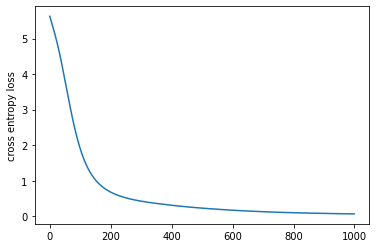

In [8]:
# 맷플롯립을 통한 오차가 줄어드는 모습 확인
plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()

오늘은 영화평 데이터를 이용해 RNN의 기본적인 쓰임새를 배우고, RNN의 단점을 보완한 GRU 모델을 이용해 텍스트 감정 분석 모델을 학습시켜보았습니다. 또한, 간단한 기계 번역 모델을 구현하여 기본적인 기계 번역 작동 원리 또한 알아보았습니다.